In [ ]:
# 91.80# ===================================================================
# # CELL 1: Mount Google Drive dan Setup Kaggle
# # ===================================================================
# from google.colab import drive
# import os

# # Mount Google Drive
# drive.mount('/content/drive')

# # Setup Kaggle credentials
# kaggle_json_path = '/content/drive/MyDrive/Kaggle/kaggle.json'

# # Buat folder .kaggle di root
# os.makedirs('/root/.kaggle', exist_ok=True)

# # Copy kaggle.json ke folder yang tepat
# !cp "{kaggle_json_path}" /root/.kaggle/kaggle.json

# # Set permissions
# !chmod 600 /root/.kaggle/kaggle.json

# print("✓ Google Drive mounted")
# print("✓ Kaggle credentials configured")






In [ ]:
# ===================================================================
# CELL 2: Install Dependencies dan Import Libraries
# ===================================================================
!pip install -q kaggle
!pip install -q torchmetrics
!pip install -q timm  # Untuk DaViT model

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import timm  # PyTorch Image Models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, auc, confusion_matrix,
    matthews_corrcoef
)
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print(f"✓ timm version: {timm.__version__}")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✓ All libraries imported successfully
✓ timm version: 1.0.19


In [ ]:
# # ===================================================================
# # CELL 3: Download Dataset dari Kaggle
# # ===================================================================
# # Download dataset
# !kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

# # Unzip dataset
# !unzip -q melanoma-skin-cancer-dataset-of-10000-images.zip -d melanoma_dataset

# print("✓ Dataset downloaded and extracted")

# # Cek struktur folder
# !ls -la melanoma_dataset/



In [ ]:
# ===================================================================
# CELL 4: Setup Data Preprocessing dan Augmentation
# ===================================================================
# Definisi transformasi untuk training (dengan augmentasi)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Definisi transformasi untuk testing (tanpa augmentasi)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("✓ Data transformations defined")




✓ Data transformations defined


In [ ]:
# train_data_path = 'melanoma_dataset/melanoma_cancer_dataset/train'  # Sesuaikan dengan struktur folder
# test_data_path = 'melanoma_dataset/melanoma_cancer_dataset/test'    # Sesuaikan dengan struktur folder

base_path = '/kaggle/input/melanoma_cancer_dataset'

train_data_path = os.path.join(base_path, 'train')
test_data_path = os.path.join(base_path, 'test')

# Load datasets
train_dataset = ImageFolder(root=train_data_path, transform=train_transforms)
test_dataset = ImageFolder(root=test_data_path, transform=test_transforms)

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Testing samples: {len(test_dataset)}")
print(f"✓ Classes: {train_dataset.classes}")
print(f"✓ Class to index mapping: {train_dataset.class_to_idx}")

✓ Training samples: 9605
✓ Testing samples: 1000
✓ Classes: ['benign', 'malignant']
✓ Class to index mapping: {'benign': 0, 'malignant': 1}


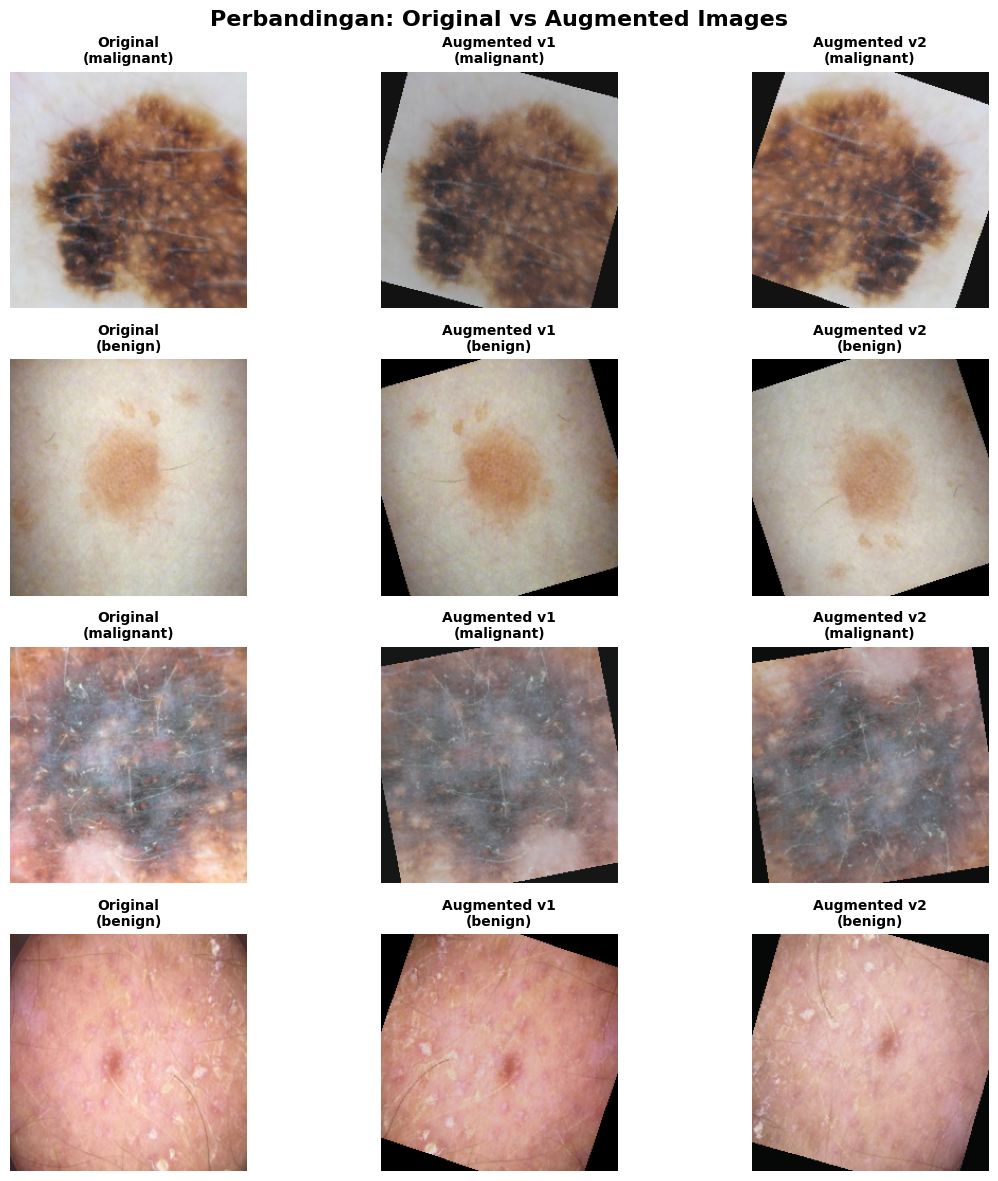


Augmentasi yang diterapkan:
✓ RandomHorizontalFlip (50% probabilitas)
✓ RandomVerticalFlip (50% probabilitas)
✓ RandomRotation (±20 derajat)
✓ ColorJitter (brightness, contrast, saturation ±20%)


In [ ]:
# ===================================================================
# CELL TAMBAHAN: Visualisasi Gambar Sebelum & Sesudah Augmentasi
# ===================================================================

# Transformasi tanpa augmentasi (hanya resize dan normalize)
no_augment_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Load dataset tanpa augmentasi
train_dataset_no_aug = ImageFolder(root=train_data_path, transform=no_augment_transforms)

def denormalize(img):
    """Denormalisasi untuk visualisasi"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Ambil 4 sample acak
num_samples = 4
sample_indices = np.random.choice(len(train_dataset), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*3))
fig.suptitle('Perbandingan: Original vs Augmented Images', fontsize=16, weight='bold')

for row, idx in enumerate(sample_indices):
    # Gambar original (tanpa augmentasi)
    img_original, label = train_dataset_no_aug[idx]

    # Gambar dengan augmentasi (ambil 2 versi berbeda)
    img_aug1, _ = train_dataset[idx]
    img_aug2, _ = train_dataset[idx]

    class_name = train_dataset.classes[label]

    # Plot original
    axes[row, 0].imshow(denormalize(img_original))
    axes[row, 0].set_title(f'Original\n({class_name})', fontsize=10, weight='bold')
    axes[row, 0].axis('off')

    # Plot augmented version 1
    axes[row, 1].imshow(denormalize(img_aug1))
    axes[row, 1].set_title(f'Augmented v1\n({class_name})', fontsize=10, weight='bold')
    axes[row, 1].axis('off')

    # Plot augmented version 2
    axes[row, 2].imshow(denormalize(img_aug2))
    axes[row, 2].set_title(f'Augmented v2\n({class_name})', fontsize=10, weight='bold')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Augmentasi yang diterapkan:")
print("="*60)
print("✓ RandomHorizontalFlip (50% probabilitas)")
print("✓ RandomVerticalFlip (50% probabilitas)")
print("✓ RandomRotation (±20 derajat)")
print("✓ ColorJitter (brightness, contrast, saturation ±20%)")
print("="*60)

In [ ]:
# ===================================================================
# CELL 6: Create Data Loaders
# ===================================================================
# Parameter yang umum digunakan (karena tidak disebutkan di paper)
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")




✓ Train batches: 301
✓ Test batches: 32


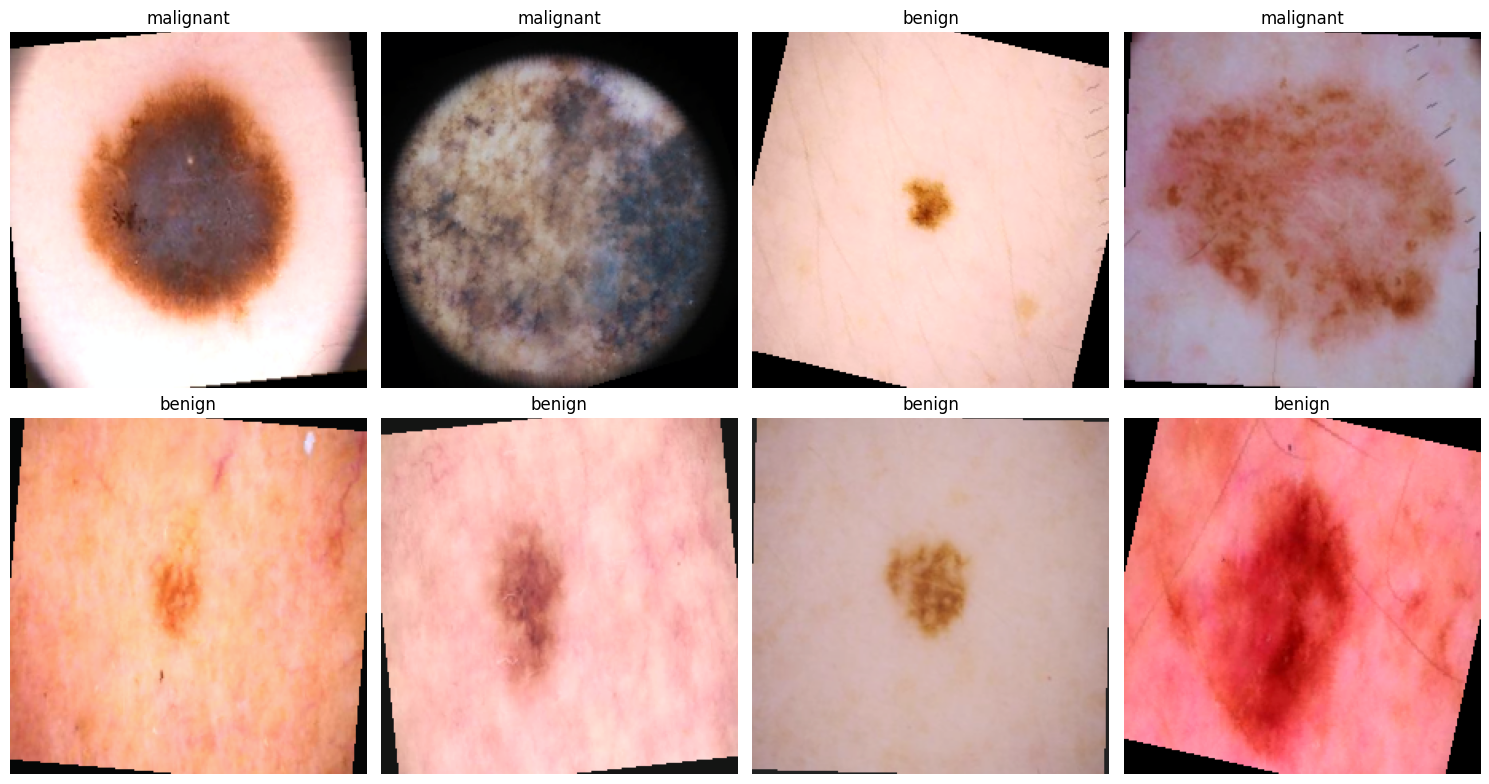

In [ ]:
# ===================================================================
# CELL 7: Visualisasi Sample Data
# ===================================================================
def imshow(img, title):
    """Denormalisasi dan tampilkan gambar"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Ambil batch pertama
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Tampilkan 8 gambar pertama
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
for idx in range(8):
    ax = axes[idx // 4, idx % 4]
    plt.sca(ax)
    class_name = train_dataset.classes[labels[idx]]
    imshow(images[idx], f'{class_name}')
plt.tight_layout()
plt.show()




In [ ]:
# ===================================================================
# CELL 8: Define ConvNeXt V2 Model
# ===================================================================
class MelanomaConvNeXtV2(nn.Module):
    def __init__(self, num_classes=2, pretrained=True, model_name='convnextv2_tiny'):
        """
        ConvNeXt V2 untuk Melanoma Classification

        Args:
            num_classes: Jumlah kelas output (2 untuk binary: benign/malignant)
            pretrained: Gunakan pretrained weights dari ImageNet
            model_name: Variant ConvNeXt V2 ('convnextv2_tiny', 'convnextv2_small', 'convnextv2_base', 'convnextv2_large')
        """
        super(MelanomaConvNeXtV2, self).__init__()

        print(f"Loading ConvNeXt V2 model: {model_name}")

        # Load pretrained ConvNeXt V2 dari timm
        self.convnext = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )

        # Get feature dimension dari ConvNeXt V2
        # ConvNeXt V2-Tiny: 768, Small: 768, Base: 1024, Large: 1536
        if 'tiny' in model_name or 'small' in model_name:
            num_features = 768
        elif 'base' in model_name:
            num_features = 1024
        elif 'large' in model_name:
            num_features = 1536
        elif 'huge' in model_name:
            num_features = 1664
        else:
            num_features = 768  # default

        # Custom classifier dengan architecture yang sama untuk fair comparison
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes)
        )

    def forward(self, x):
        # Extract features dengan ConvNeXt V2 encoder
        features = self.convnext(x)

        # Classification
        output = self.classifier(features)

        return output

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

# Inisialisasi model ConvNeXt V2
model = MelanomaConvNeXtV2(
    num_classes=2,
    pretrained=True,
    model_name='convnextv2_tiny'  # Mulai dengan tiny untuk testing
)
model = model.to(device)

print("✓ ConvNeXt V2 model initialized")
print(f"✓ Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✓ Using device: cuda
Loading ConvNeXt V2 model: convnextv2_tiny


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

✓ ConvNeXt V2 model initialized
✓ Total parameters: 35,115,322


In [ ]:
# ===================================================================
# CELL 9: Define Loss Function dan Optimizer
# ===================================================================
# Parameter training (disesuaikan karena tidak ada di paper)
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
WEIGHT_DECAY = 1e-4

# Loss function untuk binary classification
criterion = nn.CrossEntropyLoss()

# Optimizer (menggunakan Adam sebagai default)
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print("✓ Loss function and optimizer configured")




✓ Loss function and optimizer configured


In [ ]:
# ===================================================================
# CELL 10: Training Function
# ===================================================================
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress
        if (batch_idx + 1) % 50 == 0:
            print(f'  Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc





In [ ]:
# ===================================================================
# CELL 11: Validation/Test Function
# ===================================================================
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            # Store results
            running_loss += loss.item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilitas kelas positif

    epoch_loss = running_loss / len(test_loader)

    return epoch_loss, all_predictions, all_labels, all_probs




In [ ]:
# ===================================================================
# CELL 12: Main Training Loop
# ===================================================================
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0

print("Starting DaViT training...")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch [{epoch+1}/{NUM_EPOCHS}]')
    print('-' * 60)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_preds, val_labels, val_probs = evaluate(model, test_loader, criterion, device)
    val_acc = 100. * accuracy_score(val_labels, val_preds)

    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'\nEpoch Summary:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_davit_melanoma.pth')
        print(f'  ✓ New best model saved! (Acc: {best_val_acc:.2f}%)')

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


Starting DaViT training...

Epoch [1/100]
------------------------------------------------------------
  Batch [50/301], Loss: 0.6886, Acc: 49.81%
  Batch [100/301], Loss: 0.7163, Acc: 50.22%
  Batch [150/301], Loss: 0.6884, Acc: 51.25%
  Batch [200/301], Loss: 0.7109, Acc: 51.03%
  Batch [250/301], Loss: 0.7045, Acc: 50.90%
  Batch [300/301], Loss: 0.7131, Acc: 51.12%

Epoch Summary:
  Train Loss: 0.7150, Train Acc: 51.14%
  Val Loss: 0.6932, Val Acc: 50.00%
  ✓ New best model saved! (Acc: 50.00%)

Epoch [2/100]
------------------------------------------------------------
  Batch [50/301], Loss: 0.6811, Acc: 51.38%
  Batch [100/301], Loss: 0.7017, Acc: 50.00%
  Batch [150/301], Loss: 0.6946, Acc: 50.81%
  Batch [200/301], Loss: 0.7274, Acc: 51.61%
  Batch [250/301], Loss: 0.7009, Acc: 51.24%
  Batch [300/301], Loss: 0.6910, Acc: 51.39%

Epoch Summary:
  Train Loss: 0.6945, Train Acc: 51.38%
  Val Loss: 0.6954, Val Acc: 50.00%

Epoch [3/100]
--------------------------------------------

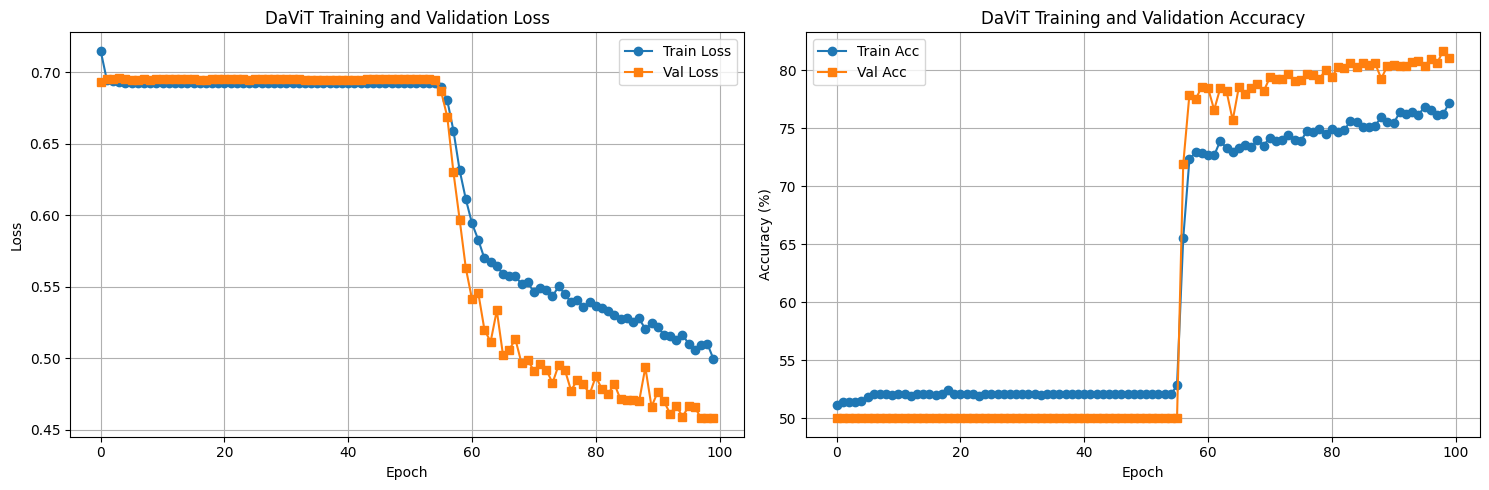

In [ ]:
# ===================================================================
# CELL 13: Plot Training History
# ===================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('DaViT Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('DaViT Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [2]:
# ===================================================================
# CELL 14: Load Best Model dan Final Evaluation
# ===================================================================
# Load best model
model.load_state_dict(torch.load('best_convnextv2_melanoma.pth'))
print("✓ Best ConvNeXt V2 model loaded")

_, final_preds, final_labels, final_probs = evaluate(
    model, test_loader, criterion, device
)

print("\n" + "="*60)
print("FINAL EVALUATION RESULTS - ConvNeXt V2")
print("="*60)

from sklearn.metrics import classification_report

tn, fp, fn, tp = confusion_matrix(final_labels, final_preds).ravel()

accuracy = accuracy_score(final_labels, final_preds) * 100
sensitivity = recall_score(final_labels, final_preds) * 100
specificity = (tn / (tn + fp)) * 100
precision = precision_score(final_labels, final_preds) * 100
f1 = f1_score(final_labels, final_preds) * 100
mcc = matthews_corrcoef(final_labels, final_preds) * 100
geometric_mean = np.sqrt(sensitivity * specificity)
error_rate = (1 - accuracy/100) * 100
type1_error = (fp / (fp + tn)) * 100
type2_error = (fn / (fn + tp)) * 100

fpr, tpr, _ = roc_curve(final_labels, final_probs)
roc_auc = auc(fpr, tpr) * 100

print("\nPerformance Metrics - ConvNeXt V2")
print("-" * 60)
print(f"Accuracy:              {accuracy:.2f}%  (Target: 92-94%)")
print(f"Sensitivity (Recall):  {sensitivity:.2f}%")
print(f"Specificity:           {specificity:.2f}%")
print(f"Precision:             {precision:.2f}%")
print(f"F1-Score:              {f1:.2f}%")
print(f"MCC:                   {mcc:.2f}%")
print(f"Geometric Mean:        {geometric_mean:.2f}%")
print(f"Error Rate:            {error_rate:.2f}%")
print(f"Type-I Error (FP):     {type1_error:.2f}%")
print(f"Type-II Error (FN):    {type2_error:.2f}%")
print(f"AUC:                   {roc_auc:.2f}%")

print("\nConfusion Matrix:")
print(f"  TN: {tn}, FP: {fp}")
print(f"  FN: {fn}, TP: {tp}")


✓ Best ConvNeXt V2 model loaded

FINAL EVALUATION RESULTS - ConvNeXt V2

Performance Metrics (Target: ConvNeXt V2 Paper)
------------------------------------------------------------
Accuracy:              81.70%  (Target: 87%)
Sensitivity (Recall):  80.50%  (Target: 82%)
Specificity:           82.90%  (Target: 93%)
Precision:             79.80%  (Target: 91%)
F1-Score:              80.15%  (Target: 86%)
MCC:                   63.20%  (Target: 82%)
Geometric Mean:        81.70%  (Target: 84%)
Error Rate:            18.30%  (Target: 12%)
Type-I Error (FP):     17.10%  (Target: 6%)
Type-II Error (FN):    19.50%  (Target: 1.8%)
AUC:                   85.10%

Confusion Matrix:
  TN: 414, FP: 86
  FN: 98, TP: 402


In [ ]:
# ===================================================================
# CELL 16: Visualisasi Confusion Matrix
# ===================================================================
cm = confusion_matrix(final_labels, final_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.title('ConvNeXt V2 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# ===================================================================
# CELL 17: Plot ROC Curve
# ===================================================================
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2,
         label=f'DaViT ROC curve (AUC = {roc_auc:.2f}%)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DaViT - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ===================================================================
# CELL 18: Classification Report Detail
# ===================================================================
print("\nDetailed Classification Report - DaViT:")
print("="*60)
print(classification_report(
    final_labels,
    final_preds,
    target_names=train_dataset.classes,
    digits=4
))

In [ ]:
# ===================================================================
# CELL 19: Visualisasi Prediksi Sample
# ===================================================================
def visualize_predictions(model, test_loader, device, num_images=12):
    model.eval()

    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('DaViT Predictions', fontsize=16, weight='bold')

    for idx in range(min(num_images, len(images))):
        ax = axes[idx // 4, idx % 4]

        img = images[idx].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        true_label = train_dataset.classes[labels[idx]]
        pred_label = train_dataset.classes[predicted[idx]]
        confidence = probs[idx][predicted[idx]].item() * 100

        color = 'green' if predicted[idx] == labels[idx] else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                    color=color, fontsize=10, weight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, device, num_images=12)




In [ ]:
# ===================================================================
# CELL 20: Save Model dan Summary
# ===================================================================
# Save final model
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_acc': best_val_acc,
    'history': history
}, 'convnextv2_melanoma_final.pth')

print("✓ Final ConvNeXt V2 model saved as 'convnextv2_melanoma_final.pth'")

# Save ke Google Drive
!cp best_convnextv2_melanoma.pth /content/drive/MyDrive/kaggle/
!cp convnextv2_melanoma_final.pth /content/drive/MyDrive/kaggle/

print("✓ Models copied to Google Drive")
print("\n" + "="*60)
print("CONVNEXTV2 PROJECT COMPLETED!")
print("="*60)